In [13]:
import pyemma
import pickle
import os
import glob
import torch

import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np

np.bool = np.bool_

from tqdm import tqdm
from matplotlib.colors import LogNorm
from itertools import combinations

blue = (70 / 255, 110 / 255, 250 / 255)
green = (100 / 255, 170 / 255, 120 / 255)

molecule = "2F4K"
simulation_idx = 0
base_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-protein"
save_dir = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-{simulation_idx}-protein"
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae2.pdb"

# Visualization

In [14]:
print(pdb_path)
pdb_traj = md.load_pdb(pdb_path)
print(pdb_traj)
pdb_view = nv.show_mdtraj(pdb_traj)
pdb_view.add_representation("licorice", selection="protein")
pdb_view

/home/shpark/prj-mlcv/lib/DESRES/data/2F4K/2F4K_from_mae2.pdb
<mdtraj.Trajectory with 1 frames, 577 atoms, 35 residues, and unitcells>


NGLWidget()

In [15]:
# Count the number of .dcd files in the simulation directory
dcd_pattern = f"{base_dir}/{molecule}-{simulation_idx}-protein-*.dcd"
dcd_files = glob.glob(dcd_pattern)
num_files = len(dcd_files)

print(f"Found {num_files} .dcd files in {base_dir}")
print(f"Pattern used: {dcd_pattern}")

# Extract the indices from filenames and sort them
file_indices = []
for file_path in dcd_files:
    filename = os.path.basename(file_path)
    # Extract the index from filename like "2JOF-0-protein-000.dcd"
    index_part = filename.split('-')[-1].replace('.dcd', '')
    if index_part.isdigit():
        file_indices.append(int(index_part))

file_indices.sort()
print(f"File indices range: {min(file_indices)} to {max(file_indices)}")
print(f"Total files to load: {len(file_indices)}")

Found 63 .dcd files in /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_2F4K-0-protein/2F4K-0-protein
Pattern used: /home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_2F4K-0-protein/2F4K-0-protein/2F4K-0-protein-*.dcd
File indices range: 0 to 62
Total files to load: 63


In [ ]:
# Load trajectories using the actual file indices found
traj_list = []
for i in tqdm(
    file_indices,
    desc="Loading trajectories"
):
    file_idx = f"{i:03d}"
    file_path = f"{base_dir}/{molecule}-{simulation_idx}-protein-{file_idx}.dcd"
    # print(file_path)
    # Check if file exists before loading
    if os.path.exists(file_path):
        traj = md.load_dcd(file_path, top=pdb_path)
        traj_list.append(traj)
    else:
        print(f"Warning: File not found: {file_path}")

all_traj = md.join(traj_list)
print(f"Successfully loaded {len(traj_list)} trajectory files")
print(f"Number of frames: {all_traj.n_frames}")

Loading trajectories: 100%|██████████| 63/63 [00:03<00:00, 16.67it/s]


Successfully loaded 63 trajectory files


In [17]:
view = nv.show_mdtraj(all_traj)
view.add_representation("licorice", selection="protein")
view

NGLWidget(max_frame=627906)

# Descriptors

In [32]:
ca_resid_pair = np.array(
    [(a.index, b.index) for a, b in combinations(list(traj.topology.residues), 2)]
)
all_traj_ca_pair_distances, _ = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(all_traj_ca_pair_distances.shape)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
ca_resid_pair = np.array(
	[(a.index, b.index) for a, b in combinations(list(traj.topology.residues), 2)]
)
print(ca_resid_pair.shape)

ca_pair_contacts, resid_pairs = md.compute_contacts(
	all_traj, scheme="ca", contacts=ca_resid_pair, periodic=False
)
print(ca_pair_contacts.shape)
print(ca_pair_contacts.mean())

ca_pair_contacts = torch.from_numpy(ca_pair_contacts)
torch.save(ca_pair_contacts, f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance.pt")

(2415, 2)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [13]:
exp = torch.tensor(2)
ca_pair_distances_swtich = (1 - (torch.pow(ca_pair_contacts, exp) / 0.8)) / (1 - (torch.pow(ca_pair_contacts, exp) / 0.8))
print(ca_pair_distances_swtich.shape)
print(ca_pair_distances_swtich.mean())
torch.save(ca_pair_distances_swtich, f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-CAdistance-switch.pt")

torch.Size([1044000, 190])
tensor(1.)


In [14]:
xyz = all_traj.xyz
print(xyz.shape)

torch.save(torch.from_numpy(xyz), f"../DESRES-Trajectory_{molecule}-{simulation_idx}-protein/{molecule}-{simulation_idx}-pos-nano.pt")

(1044000, 272, 3)


# TICA

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

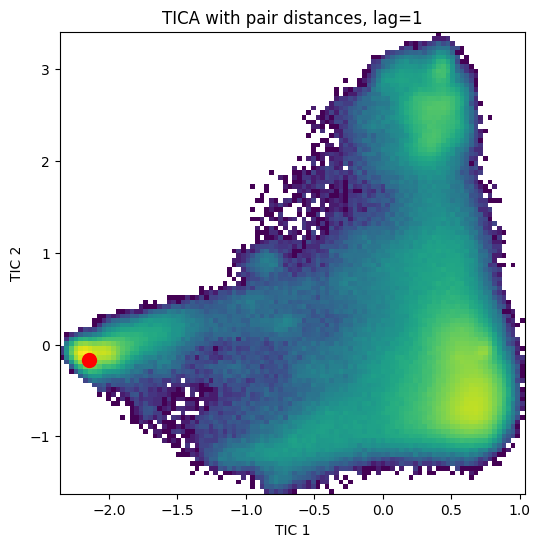

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

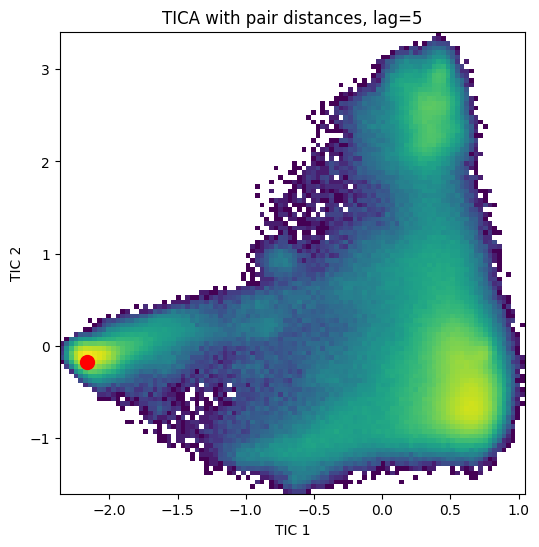

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

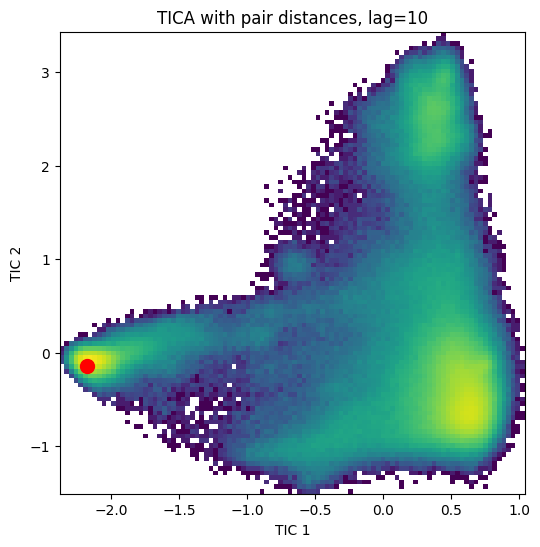

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

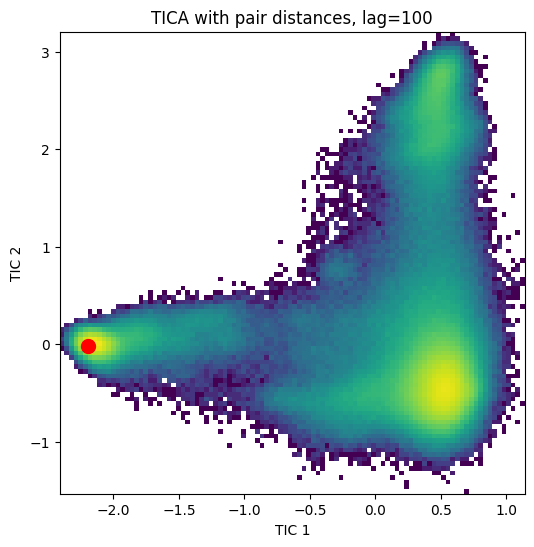

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

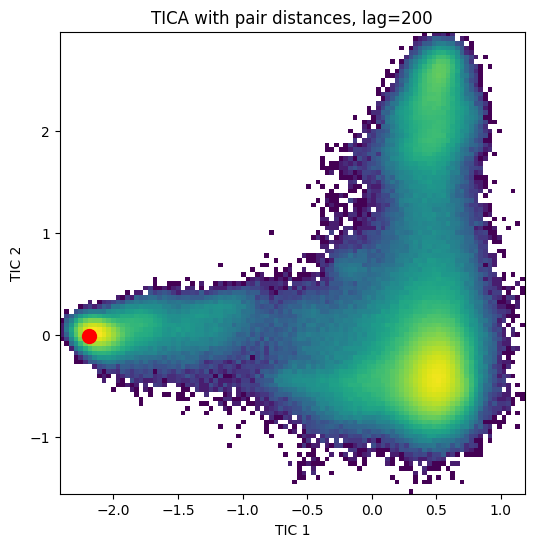

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

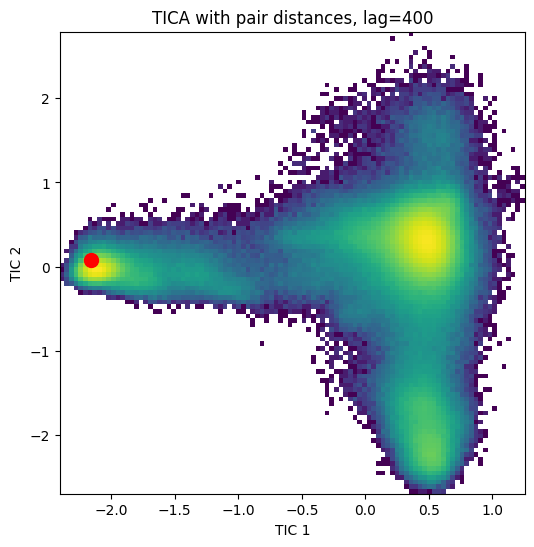

/home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/shpark/.conda/envs/bioemu4/lib/python3.10/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3 [00:00<?, ?it/s]

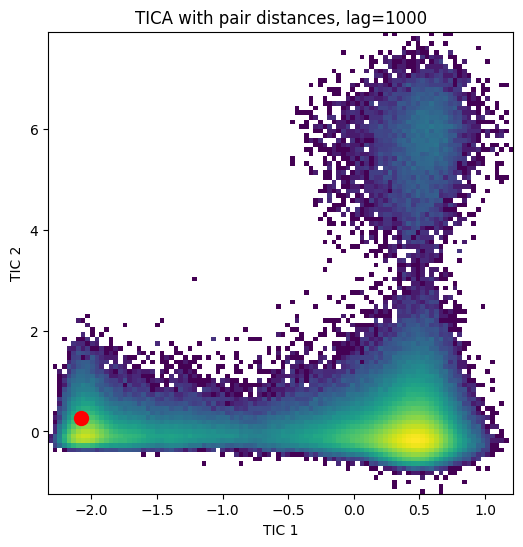

In [21]:
# TICA with pair distances
pdb_state = md.load(pdb_path)
pdb_state_ca_pair_distances, pdb_resid_pairs = md.compute_contacts(pdb_state, scheme="ca", contacts=ca_resid_pair, periodic=False)

for lag in (1, 5, 10, 100, 200, 400, 1000):
	data = ca_pair_contacts
	tica_obj = pyemma.coordinates.tica(data, lag=lag, dim=2)
	tica_data = tica_obj.get_output()[0]
	x = tica_data[:, 0]
	y = tica_data[:, 1]

	pdb_tica_data = tica_obj.transform(pdb_state_ca_pair_distances)
	pdb_tica_x = pdb_tica_data[:, 0]
	pdb_tica_y = pdb_tica_data[:, 1]

	# Plot
	fig = plt.figure(figsize=(6, 6))
	ax = fig.add_subplot(111)
	ax.hist2d(x, y, bins=100, norm=LogNorm())
	ax.scatter(pdb_tica_x, pdb_tica_y, color="red", s=100)
	ax.set_xlabel("TIC 1")
	ax.set_ylabel("TIC 2")
	plt.title(f"TICA with pair distances, lag={lag}")
	plt.savefig(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.png')
	plt.show()
	plt.close()

	with open(f'../data/{molecule}/{molecule}_tica_model_lag{lag}.pkl', 'wb') as f:
		pickle.dump(tica_obj, f)

# State and bonds


Below needs to be re-defined...

## States

In [6]:
def label_by_hbond(
    traj,
    distance_cutoff=0.35,
    angle_cutoff=110,
    bond_number_cutoff=3
):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	# TYR1N-YR10OT1
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	hydrogen_idx, hydrogen_idx, hydrogen_idx_3 = 1, 2, 3   # Tyr10:H
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	angle_2 = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	angle_3 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_3, acceptor_idx]]) * (180.0 / np.pi)
	label_O1 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff) & (angle_2[:,0] > angle_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff) & (angle_3[:,0] > angle_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3


	# TYR1N-YR10OT2
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	hydrogen_idx_1, hydrogen_idx_2, hydrogen_idx_3 = 1, 2, 3   # Tyr10:H
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle_1 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_1, acceptor_idx]]) * (180.0 / np.pi)
	angle_2 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_2, acceptor_idx]]) * (180.0 / np.pi)
	angle_3 = md.compute_angles(traj, [[donor_idx, hydrogen_idx_3, acceptor_idx]]) * (180.0 / np.pi)
	label_O1 = ((distance[:,0] < distance_cutoff) & (angle_1[:,0] > angle_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff) & (angle_2[:,0] > angle_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff) & (angle_3[:,0] > angle_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3


	# ASP3N-TYR8O
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	hydrogen_idx = 45
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
 
	# THR6OG1-ASP3O
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	hydrogen_idx = 92
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
 
	# THR6N-ASP3OD1
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	hydrogen_idx = 86
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
	# THR6N-ASP3OD2
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	hydrogen_idx = 86
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 
 
	# GLY7N-ASP3O
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	hydrogen_idx = 100
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)
 

	# TYR10N-TYR1O
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	hydrogen_idx = 145
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	angle = md.compute_angles(traj, [[donor_idx, hydrogen_idx, acceptor_idx]]) * (180.0 / np.pi)
	labels_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff) & (angle[:,0] > angle_cutoff)).astype(int)




	# ASP3OD_THR6OG1_ASP3N_THR8O
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + labels_ASP3N_TYR8O + labels_THR6OG1_ASP3O \
		+ labels_THR6N_ASP3OD1 + labels_THR6N_ASP3OD2 + labels_GLY7N_ASP3O + labels_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff

	# print(label_TYR10OT_TYR1N.sum())
	# print(labels_TYR10N_TYR1O.sum())
	# print(labels_ASP3OD_THR6OG1.sum())
	# print(labels_ASP3N_TYR8O.sum())

	return labels, bond_sum

def label_by_hbond_distance(
    traj,
    distance_cutoff=0.35,
    bond_number_cutoff=3
):
	"""
	Generate binary labels for folded/unfolded states based at least 3 bonds among eight bonds
	- TYR1T-YR10OT1
	- TYR1T-YR10OT2
	- ASP3N-TYR8O
	- THR6OG1-ASP3O
	- THR6N-ASP3OD1
	- THR6N-ASP3OD2
	- TYR10N-TYR1O


	Args:
		traj (mdtraj): mdtraj trajectory object
		distance_cutoff (float): donor-acceptor distance cutoff in nm (default 0.35 nm = 3.5 amstrong)
		angle_cutoff (float): hydrogen bond angle cutoff in degrees (default 110 deg)
		bond_number_cutoff (int): minimum number of bonds to be considered as folded (default 3)

	Returns:
		labels (np.array): binary array (1: folded, 0: unfolded)
	"""
	# TYR1N-YR10OT1
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name O')[0]   # Tyr10:OT1
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int) 
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT1 = label_O1 | label_O2 | label_O3


	# TYR1N-YR10OT2
	donor_idx = traj.topology.select('residue 1 and name N')[0] # Tyr1:N
	acceptor_idx = traj.topology.select('residue 10 and name OXT')[0]   # Tyr10:OT2
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_O1 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O2 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_O3 = ((distance[:,0] < distance_cutoff)).astype(int)
	label_TYR1N_TYR10OT2 = label_O1 | label_O2 | label_O3


	# ASP3N-TYR8O
	donor_idx = traj.topology.select('residue 3 and name N')[0]
	acceptor_idx = traj.topology.select('residue 8 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_ASP3N_TYR8O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6OG1-ASP3O
	donor_idx = traj.topology.select('residue 6 and name OG1')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6OG1_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# THR6N-ASP3OD1
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD1')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD1 = ((distance[:,0] < distance_cutoff)).astype(int)
 
	# THR6N-ASP3OD2
	donor_idx = traj.topology.select('residue 6 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name OD2')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_THR6N_ASP3OD2 = ((distance[:,0] < distance_cutoff)).astype(int)
 
 
	# GLY7N-ASP3O
	donor_idx = traj.topology.select('residue 7 and name N')[0]
	acceptor_idx = traj.topology.select('residue 3 and name O')[0]
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_GLY7N_ASP3O = ((distance[:,0] < distance_cutoff)).astype(int)
 

	# TYR10N-TYR1O
	donor_idx = traj.topology.select('residue 10 and name N')[0] 
	acceptor_idx = traj.topology.select('residue 1 and name O')[0] 
	distance = md.compute_distances(traj, [[donor_idx, acceptor_idx]])
	label_TYR10N_TYR1O = ((distance[:,0] < distance_cutoff)).astype(int)

	# ASP3OD_THR6OG1_ASP3N_THR8O
	bond_sum = label_TYR1N_TYR10OT1 + label_TYR1N_TYR10OT2 + label_ASP3N_TYR8O + label_THR6OG1_ASP3O \
		+ label_THR6N_ASP3OD1 + label_THR6N_ASP3OD2 + label_GLY7N_ASP3O + label_TYR10N_TYR1O
	labels = bond_sum >= bond_number_cutoff

	return labels, bond_sum

In [7]:
label_distance, bond_num_distance = label_by_hbond_distance(all_traj)
print(label_distance.shape)
print(bond_num_distance.shape)

label_distance_angle, bond_num_distance_angle = label_by_hbond(all_traj)
print(label_distance_angle.shape)
print(bond_num_distance_angle.shape)

(530000,)
(530000,)
(530000,)
(530000,)


In [63]:
folded_state_distance = label_distance.sum()
print("Foldedness by H bond distance")
print(f"Folded: {folded_state_distance} / {label_distance.shape[0]} ({folded_state_distance / label_distance.shape[0] * 100:.2f}%)")
print(f"Unfolded: {label_distance.shape[0] - folded_state_distance} / {label_distance.shape[0]} ({(label_distance.shape[0] - folded_state_distance) / label_distance.shape[0] * 100:.2f}%)")

folded_state_distance_angle = label_distance_angle.sum()
print("\nFoldedness by H bond distance and angle")
print(f"Folded: {folded_state_distance_angle} / {label_distance_angle.shape[0]} ({folded_state_distance_angle / label_distance_angle.shape[0] * 100:.2f}%)")
print(f"Unfolded: {label_distance_angle.shape[0] - folded_state_distance_angle} / {label_distance_angle.shape[0]} ({(label_distance_angle.shape[0] - folded_state_distance_angle) / label_distance_angle.shape[0] * 100:.2f}%)")

Foldedness by H bond distance
Folded: 410460 / 530000 (77.45%)
Unfolded: 119540 / 530000 (22.55%)

Foldedness by H bond distance and angle
Folded: 387679 / 530000 (73.15%)
Unfolded: 142321 / 530000 (26.85%)


In [ ]:
# torch.save(torch.from_numpy(label_distance), f"{save_dir}/{molecule}-{simulation_idx}-label_distance.pt")
# torch.save(torch.from_numpy(bond_num_distance), f"{save_dir}/{molecule}-{simulation_idx}-bond_num_distance.pt")
# torch.save(torch.from_numpy(label_distance_angle), f"{save_dir}/{molecule}-{simulation_idx}-label_distance_angle.pt")
# torch.save(torch.from_numpy(bond_num_distance_angle), f"{save_dir}/{molecule}-{simulation_idx}-bond_num_distance_angle.pt")

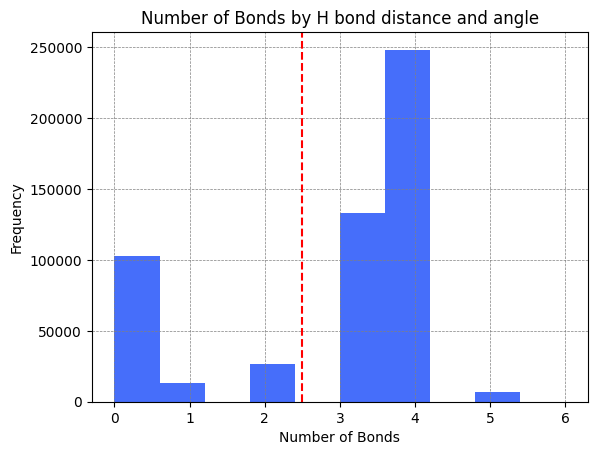

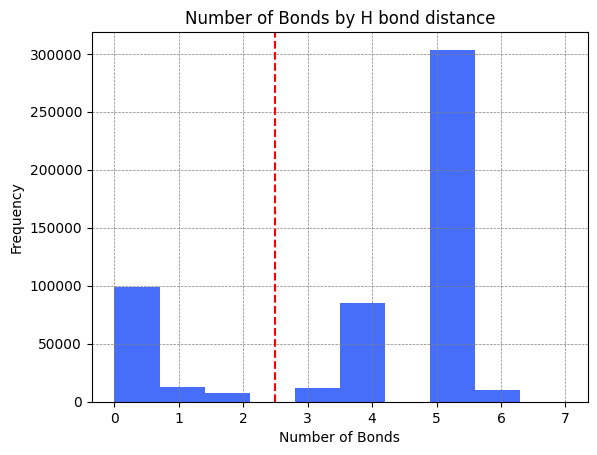

In [88]:
plt.hist(bond_num_distance_angle, color=blue, align='mid')
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both') 
plt.axvline(2.5, color="red", linestyle="--")
plt.xlabel('Number of Bonds')
plt.ylabel('Frequency')
plt.title('Number of Bonds by H bond distance and angle')
plt.savefig(f'{save_dir}/{molecule}-{simulation_idx}-bond_num_distance_angle.png')
plt.show()

plt.hist(bond_num_distance, color=blue, align='mid')
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both') 
plt.axvline(2.5, color="red", linestyle="--")
plt.xlabel('Number of Bonds')
plt.ylabel('Frequency')
plt.title('Number of Bonds by H bond distance')
plt.savefig(f'{save_dir}/{molecule}-{simulation_idx}-bond_num_distance.png')
plt.show()